In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.4.1 cuda: True


In [2]:
## Load dataset
data_path = "../gmm_dataset_c20k"
Data = torch.from_numpy(np.load(data_path + '/obs.npy')).float()

NUM_DATASETS, N, D = Data.shape
K = 3 ## number of clusters
SAMPLE_SIZE = 10
NUM_HIDDEN_LOCAL = 32

BATCH_SIZE = 20
NUM_EPOCHS = 1000
LEARNING_RATE = 1e-4
CUDA = torch.cuda.is_available()
PATH = 'baseline-mlp-%dsamples' % (SAMPLE_SIZE)
DEVICE = torch.device('cuda:0')

Train_Params = (NUM_EPOCHS, NUM_DATASETS, SAMPLE_SIZE, BATCH_SIZE, CUDA, DEVICE, PATH)
Model_Params = (N, K, D)

In [3]:
from local_enc import *
from global_oneshot import *
## if reparameterize continuous variables
Reparameterized = False
# initialization
enc_z = Enc_z(K, D, NUM_HIDDEN_LOCAL, CUDA, DEVICE)
oneshot_eta = Oneshot_eta(K, D, CUDA, DEVICE, Reparameterized)
if CUDA:
    enc_z.cuda().to(DEVICE)
    oneshot_eta.cuda().to(DEVICE)
optimizer =  torch.optim.Adam(list(oneshot_eta.parameters())+list(enc_z.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))
models = (oneshot_eta, enc_z)

In [4]:
from os_ep import *
train_baseline(models, EP, optimizer, Data, Model_Params, Train_Params)

epoch: 0\1000 (11s),  eubo: -622.195,  elbo: -744.092,  ess: 1.064
epoch: 1\1000 (9s),  eubo: -541.837,  elbo: -624.192,  ess: 1.108
epoch: 2\1000 (11s),  eubo: -498.607,  elbo: -564.054,  ess: 1.144
epoch: 3\1000 (11s),  eubo: -468.488,  elbo: -521.809,  ess: 1.171
epoch: 4\1000 (11s),  eubo: -449.283,  elbo: -492.679,  ess: 1.214
epoch: 5\1000 (10s),  eubo: -436.655,  elbo: -475.100,  ess: 1.225
epoch: 6\1000 (8s),  eubo: -430.695,  elbo: -465.384,  ess: 1.232
epoch: 7\1000 (11s),  eubo: -420.287,  elbo: -454.793,  ess: 1.270
epoch: 8\1000 (11s),  eubo: -420.876,  elbo: -455.345,  ess: 1.298
epoch: 9\1000 (11s),  eubo: -418.688,  elbo: -454.164,  ess: 1.293
epoch: 10\1000 (8s),  eubo: -411.491,  elbo: -444.473,  ess: 1.333
epoch: 11\1000 (10s),  eubo: -416.200,  elbo: -450.760,  ess: 1.347
epoch: 12\1000 (11s),  eubo: -410.524,  elbo: -443.419,  ess: 1.349
epoch: 13\1000 (11s),  eubo: -404.084,  elbo: -437.391,  ess: 1.373
epoch: 14\1000 (11s),  eubo: -408.640,  elbo: -440.529,  ess:

In [10]:
# torch.save(enc_z.state_dict(), '../weights/enc-z-%s' + PATH)
# torch.save(oneshot_eta.state_dict(), '../weights/oneshot-eta-%s' + PATH)

In [11]:
def test(models, objective, Data, Model_Params, Train_Params):
    (NUM_EPOCHS, NUM_DATASETS, S, B, CUDA, device, path) = Train_Params
    SubTrain_Params = (device, S, B) + Model_Params
    ##(N, K, D, mcmc_size) = Model_Params
#     indices = torch.randperm(NUM_DATASETS)
    step = 2
    indices = torch.arange(NUM_DATASETS)
    batch_indices = indices[0*B : (0+1)*B]
    obs = Data[batch_indices]
    obs = shuffler(obs).repeat(S, 1, 1, 1)
    if CUDA:
        obs =obs.cuda().to(device)
    loss, metric_step, reused = objective(models, obs, SubTrain_Params)
    return obs, metric_step, reused

In [12]:
BATCH_SIZE_TEST = 50
Train_Params_Test = (NUM_EPOCHS, NUM_DATASETS, SAMPLE_SIZE, BATCH_SIZE_TEST, CUDA, DEVICE, PATH)
obs, metric_step, reused = test(models, EP, Data, Model_Params, Train_Params_Test)
(q_eta, _, q_z, _, _, _) = reused

# def plot_samples(obs, q_eta, q_z, PATH):
#     colors = ['r', 'b', 'g']
#     fig = plt.figure(figsize=(25,50))
#     xs = obs[0].cpu().data.numpy()
#     E_z = q_z['zs'].dist.probs[0].cpu().data.numpy()
#     batch_size, N, K = E_z.shape
#     _, _, D = xs.shape
#     E_mu = q_eta['means'].dist.loc[0].cpu().data.numpy()
#     E_tau = (q_eta['precisions'].dist.concentration[0] / q_eta['precisions'].dist.rate[0]).cpu().data.numpy()
#     for b in range(batch_size):
#         ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
#         xb = xs[b]
#         zb = E_z[b]
#         mu = E_mu[b].reshape(K, D)
#         sigma2 = 1. / E_tau[b]
#         assignments = zb.argmax(-1)
#         for k in range(K):
#             cov_k = np.diag(sigma2[k])
#             xk = xb[np.where(assignments == k)]
#             ax.scatter(xk[:, 0], xk[:, 1], c=colors[k])
#             plot_cov_ellipse(cov=cov_k, pos=mu[k], nstd=2, ax=ax, alpha=0.2, color=colors[k])
#         ax.set_ylim([-15, 15])
#         ax.set_xlim([-15, 15])
#     plt.savefig('../results/modes-' + PATH + '.svg')

CPU times: user 3.34 s, sys: 23.9 ms, total: 3.36 s
Wall time: 3.37 s


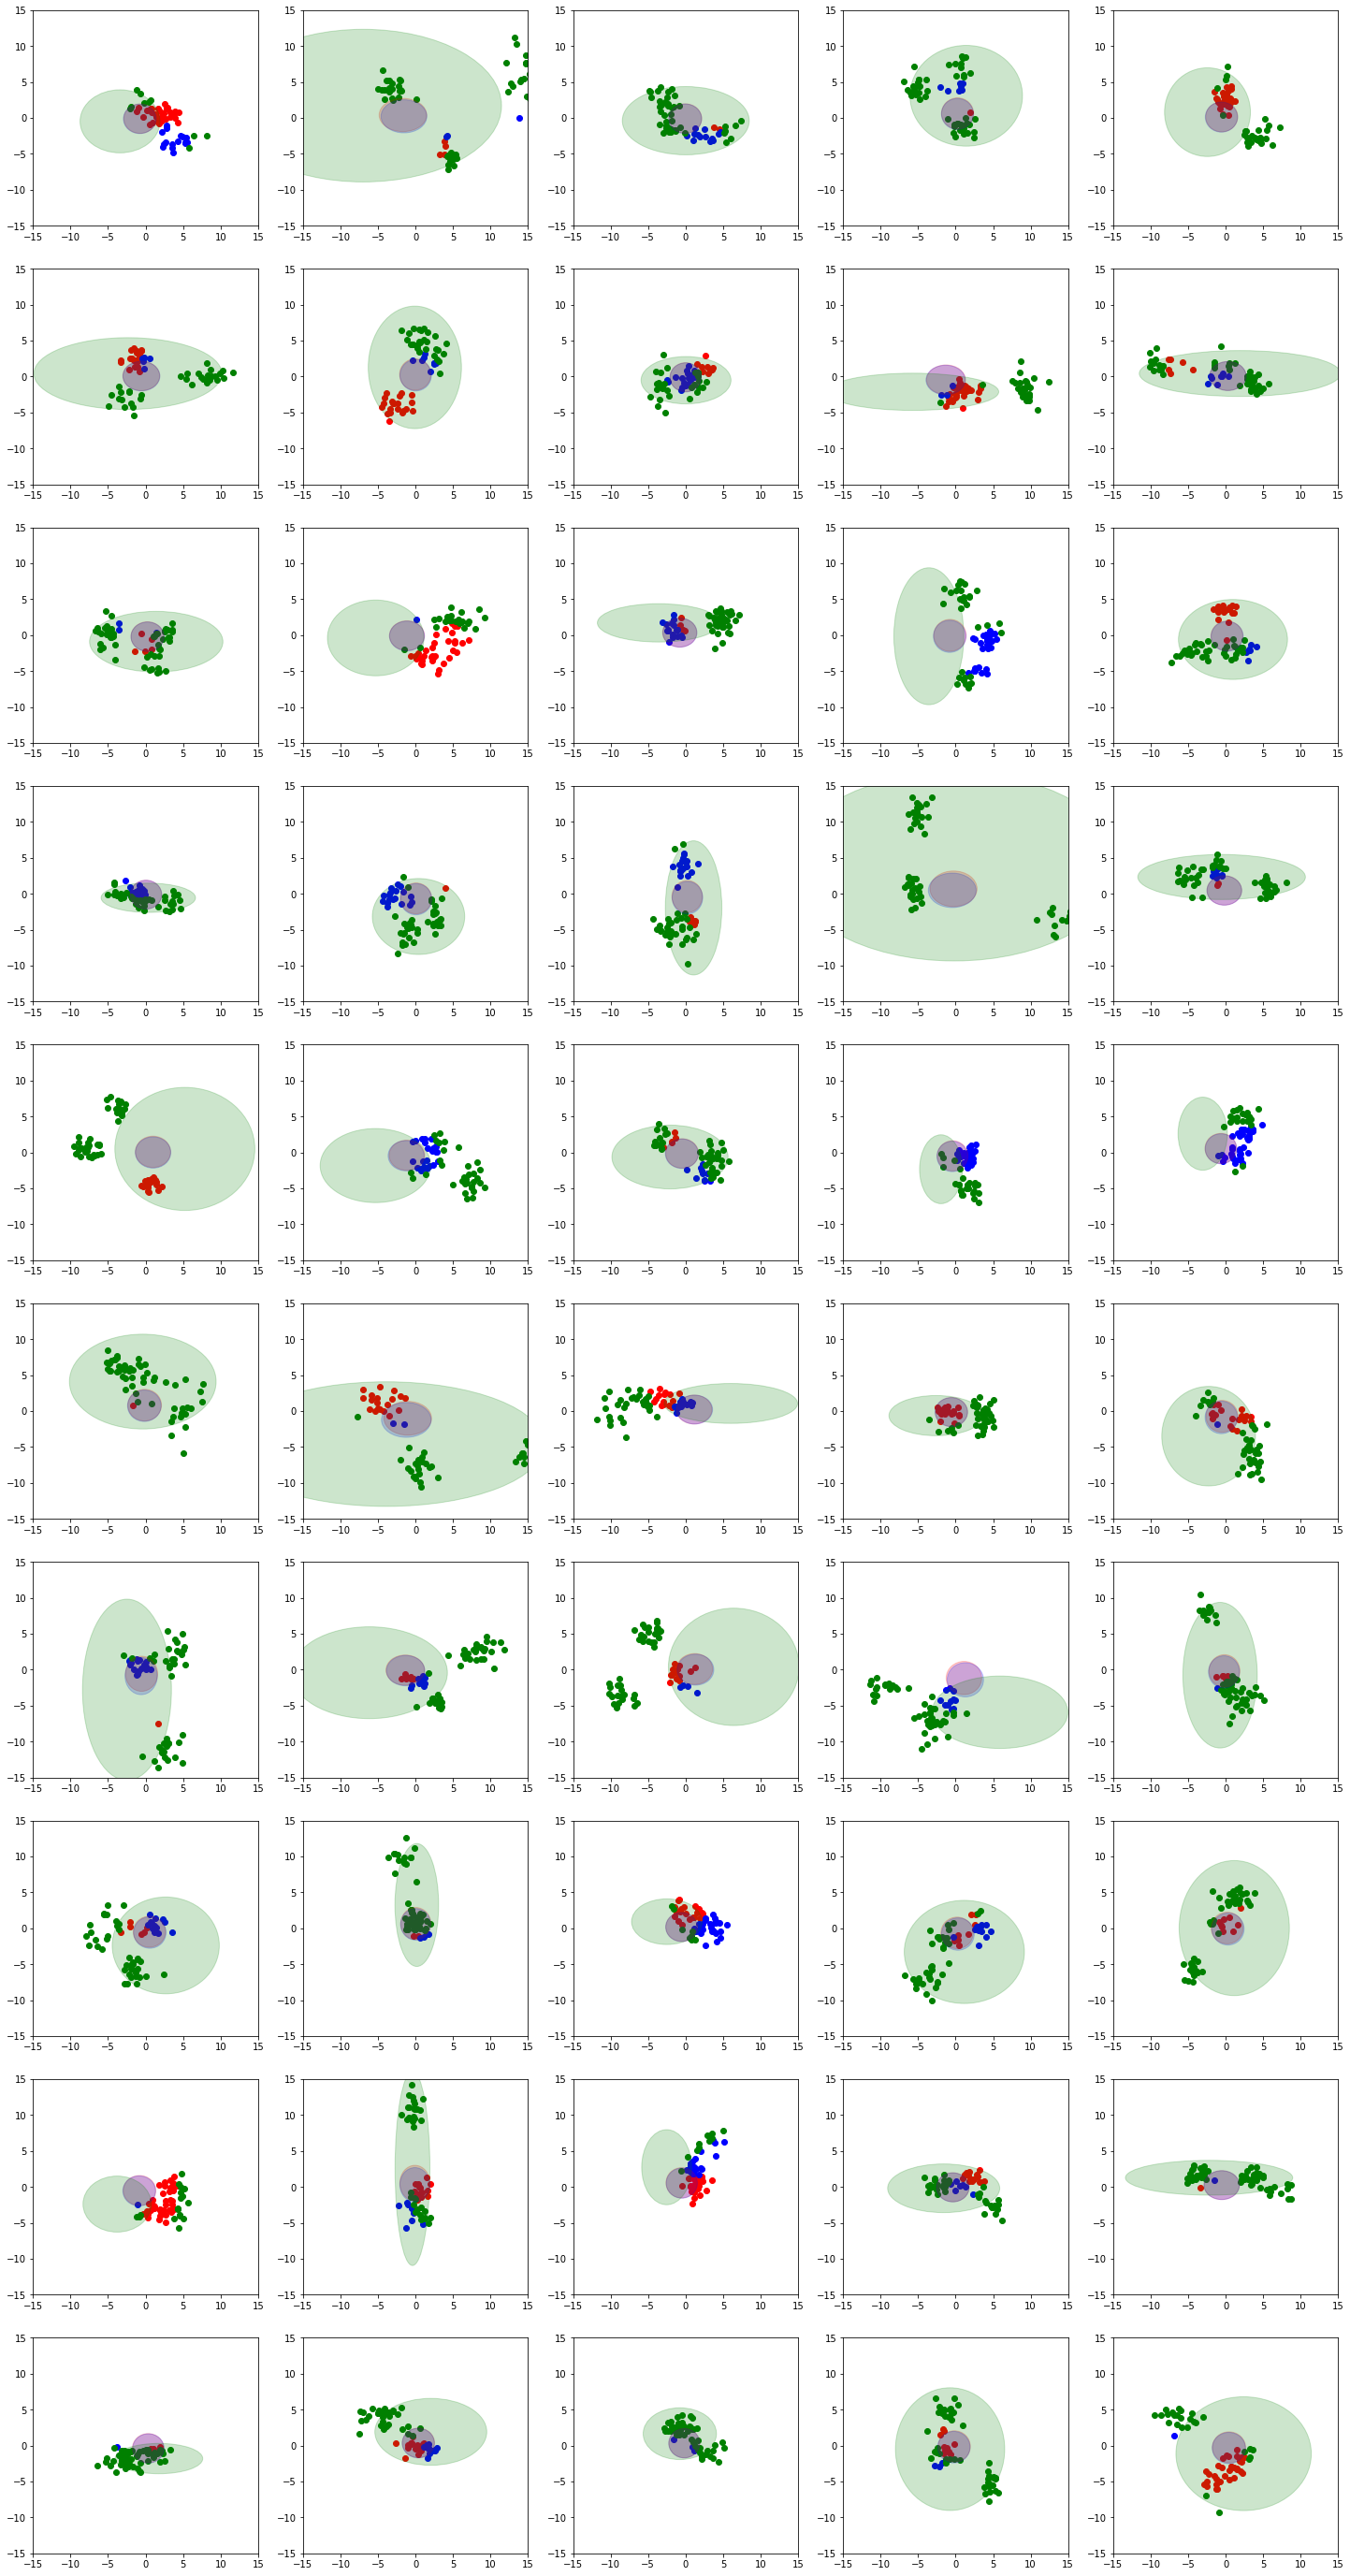

In [13]:
%time plot_samples(obs, q_eta, q_z, PATH)

In [9]:
incremental_gap = symkl_test.cpu().data.numpy()[1:]
M = incremental_gap.shape[0]
overall_gap = np.zeros(M)
for m in range(M):
    overall_gap[m] = incremental_gap[:m+1].sum()

NameError: name 'symkl_test' is not defined

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.yscale("log")
ax.plot(incremental_gap, label="incremental gap")
ax.plot(overall_gap, label='overall gap')
ax.legend(fontsize=14)
ax.set_xlabel('Steps')

In [ ]:
incremental_gap